In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

import seaborn as sns
sns.set_theme(style="ticks", color_codes=True)


from collections import Counter, defaultdict


from sklearn import preprocessing
# from sklearn import manifold
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import TimeSeriesSplit


from sklearn import metrics

from scipy.stats import sem, t
from scipy import mean

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler



In [2]:
df = pd.read_csv('daily data.csv')
df.head()

,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,...,solarenergy,uvindex,conditions,Ozono (µg/m3),Dióxido de Azoto (µg/m3),Óxidos de Azoto (µg/m3),Monóxido de Azoto (µg/m3),pollen_intensity,admission number,risk level
0,2019-01-01,16.0,7.6,11.5,16.0,6.6,11.4,5.1,66.2,0.000,...,10.3,5,Clear,12.0,42.45,54.55,7.50,good,5,high risk
1,2019-01-02,15.9,7.6,10.9,15.9,6.2,10.5,7.4,80.2,0.000,...,4.8,3,Clear,25.0,39.70,46.30,3.65,good,3,moderate risk
2,2019-01-03,10.3,4.5,7.4,10.3,2.2,6.3,6.1,91.7,0.005,...,10.2,5,Rain,9.0,34.90,76.95,26.65,good,1,low risk
3,2019-01-04,13.1,6.6,9.7,13.1,4.1,8.7,6.9,84.1,0.000,...,8.8,5,Clear,22.0,36.35,55.10,3.10,good,5,high risk
4,2019-01-05,14.8,7.8,10.5,14.8,6.0,9.9,5.5,71.4,0.000,...,11.1,5,Clear,34.5,31.75,39.15,2.55,good,2,moderate risk


In [3]:
toDrop = ['data_admissao', 'dicofre', 'distrito', 'concelho', 'freguesia', 'regiao', 'nacionalidade',
         'cod_proveniencia', 'proveniencia', 'cod_causa', 'causa', 'cod_destino', 'destino',
         'diagnostico', 'classe', 'asma', 'date', 'name','snow', 'snowdepth', 'winddir', 'cor',
         'severerisk', 'sunrise', 'sunset', 'stations', 'icon', 'description', 'preciptype',
         'moonphase', 'windgust', 'feelslikemax', 'feelslikemin', 'feelslike', 'uvindex', 'precipprob',
         'precipcover', 'visibility', 'solarradiation', 'solarenergy', 'sealevelpressure',
          'cloudcover']

In [4]:
for col in df:
    if col  in toDrop:
        df.drop(col, axis=1, inplace=True)

In [5]:
# conditions
# pollen_intensity

# Get one hot encoding of columns conditions
one_hot = pd.get_dummies(df['conditions'])
# Drop column conditions as it is now encoded
df = df.drop('conditions',axis = 1)
# Join the encoded df
df = df.join(one_hot)
df

,datetime,tempmax,tempmin,temp,dew,humidity,precip,windspeed,pollen_intensity,admission number,risk level,Clear,Partially cloudy,Rain,"Rain, Overcast","Rain, Partially cloudy"
0,2019-01-01,16.0,7.6,11.5,5.1,66.2,0.000,11.1,good,5,high risk,1,0,0,0,0
1,2019-01-02,15.9,7.6,10.9,7.4,80.2,0.000,16.4,good,3,moderate risk,1,0,0,0,0
2,2019-01-03,10.3,4.5,7.4,6.1,91.7,0.005,12.6,good,1,low risk,0,0,1,0,0
3,2019-01-04,13.1,6.6,9.7,6.9,84.1,0.000,16.8,good,5,high risk,1,0,0,0,0
4,2019-01-05,14.8,7.8,10.5,5.5,71.4,0.000,14.9,good,2,moderate risk,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451,2020-03-27,17.9,10.1,13.3,7.0,67.0,0.000,18.1,good,0,low risk,0,1,0,0,0
452,2020-03-28,17.2,9.9,13.5,5.9,60.9,0.000,23.9,good,1,low risk,0,1,0,0,0
453,2020-03-29,18.4,11.0,14.4,9.6,73.6,0.000,21.9,good,0,low risk,0,1,0,0,0
454,2020-03-30,13.5,9.1,12.3,10.8,90.7,8.742,28.7,good,1,low risk,0,0,0,0,1


In [6]:
for i in range(len(df['pollen_intensity'])):
    if df.loc[i, 'pollen_intensity'] == 'good':
        df.loc[i, 'pollen_intensity'] = 1
    elif df.loc[i, 'pollen_intensity'] == 'baixos':
        df.loc[i, 'pollen_intensity'] = 2
    elif df.loc[i, 'pollen_intensity'] == 'elevados':
        df.loc[i, 'pollen_intensity'] = 3
    elif df.loc[i, 'pollen_intensity'] == 'muito elevados':
        df.loc[i, 'pollen_intensity'] = 4
df['pollen_intensity'].value_counts()

1    351
4     56
3     28
2     21
Name: pollen_intensity, dtype: int64

In [7]:
## Adding feature
df['tem amplitude'] = df['tempmax'] - df['tempmin']
df.drop(['tempmax', 'tempmin'], axis=1, inplace=True)

In [8]:
X = pd.DataFrame()
for col in df.columns:
    try:
        df[col] = df[col].astype(float)
        X[col] = df[col]
    except:
        print(col)
X.drop(['admission number'], axis=1, inplace=True)
# X

datetime
risk level


In [9]:
tempChange = []
for i in range(len(X)):
    try:
#         print(X.loc[i, 'temp'] , X.loc[i-1, 'temp'],(X.loc[i, 'temp'] - X.loc[i-1, 'temp']))
        tempChange.append((X.loc[i, 'temp'] - X.loc[i-1, 'temp']))
#         break
    except:
        tempChange.append(0)
        
X['temp cahnge'] = tempChange

# X[['tem amplitude', 'admission number', 'temp cahnge', 'temp', 'humidity']].corr()

In [10]:
tempChange2 = []
for i in range(len(X)):
    try:
#         print(X.loc[i, 'temp'] , X.loc[i-1, 'temp'],(X.loc[i, 'temp'] - X.loc[i-1, 'temp']))
        tempChange2.append((X.loc[i, 'temp'] - X.loc[i-2, 'temp']))
#         break
    except:
        tempChange2.append(0)
        
X['temp cahnge2'] = tempChange2

# X.plot.scatter('temp cahnge2', 'admission number')

In [11]:
y = [1 if risk=='low risk' else 2 if risk=='moderate risk' else 3 for risk in df['risk level']]
Counter(y)
# y = []
# for risk in df['risk level']:

Counter({3: 111, 2: 183, 1: 162})

In [12]:

clf = DecisionTreeClassifier()
# iris = load_iris()
cross_val_score(clf, X, y, cv=10)


array([0.45652174, 0.17391304, 0.30434783, 0.36956522, 0.39130435,
       0.41304348, 0.42222222, 0.37777778, 0.4       , 0.33333333])

In [13]:
xtrian, xtext, ytrain, ytest = train_test_split(X, y, test_size=0.1)
clf.fit(xtrian, ytrain)
y_pred = clf.predict(xtext)
confusion_matrix(ytest, y_pred)

array([[ 4,  8,  2],
       [ 9, 10,  1],
       [ 5,  1,  6]])

In [14]:
scaler = MinMaxScaler()
xcolumns = X.columns
X = scaler.fit_transform(X)
X = pd.DataFrame(X, columns=xcolumns)

In [15]:
y = pd.DataFrame(y)

In [16]:
tscv = TimeSeriesSplit(n_splits=3)
print(tscv)
TimeSeriesSplit(max_train_size=None, n_splits=3)
for train_index, test_index in tscv.split(X.values):
#     print('TRAIN:', train_index, 'TEST:', test_index) 
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None)
[[20  5 20]
 [20  6 23]
 [ 8  3  9]]
              precision    recall  f1-score   support

           1       0.42      0.44      0.43        45
           2       0.43      0.12      0.19        49
           3       0.17      0.45      0.25        20

    accuracy                           0.31       114
   macro avg       0.34      0.34      0.29       114
weighted avg       0.38      0.31      0.30       114

[[24 16  6]
 [22 10  7]
 [16  9  4]]
              precision    recall  f1-score   support

           1       0.39      0.52      0.44        46
           2       0.29      0.26      0.27        39
           3       0.24      0.14      0.17        29

    accuracy                           0.33       114
   macro avg       0.30      0.31      0.30       114
weighted avg       0.31      0.33      0.32       114

[[16 13  9]
 [11 23 12]
 [13 12  5]]
              precision    recall  f1-score   support



In [17]:
y = pd.DataFrame(y)

In [18]:
regDT = DecisionTreeRegressor ()
tscv = TimeSeriesSplit(max_train_size=None, n_splits=len(X)-1)

print(tscv)
error = []
i = 0
for train_index, test_index in tscv.split(X.values):
    if len(train_index) < 20:
        continue
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    regDT.fit(X_train, y_train)
    y_pred = regDT.predict(X_test)
    error.append(metrics.mean_squared_error(y_test, y_pred))
    i += 1



TimeSeriesSplit(gap=0, max_train_size=None, n_splits=455, test_size=None)


In [19]:
error

[1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 4.0,
 4.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 4.0,
 1.0,
 4.0,
 4.0,
 1.0,
 1.0,
 1.0,
 4.0,
 0.0,
 4.0,
 4.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 4.0,
 1.0,
 4.0,
 1.0,
 1.0,
 0.0,
 4.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 4.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 4.0,
 1.0,
 4.0,
 0.0,
 0.0,
 1.0,
 4.0,
 1.0,
 0.0,
 0.0,
 4.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 4.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 4.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 4.0,
 1.0,
 0.0,
 0.0,
 4.0,
 0.0,
 1.0,
 4.0,
 1.0,
 4.0,
 0.0,
 4.0,
 1.0,
 4.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 4.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 4.0,
 1.0,
 4.0,
 1.0,
 4.0,
 1.0,
 1.0,
 0.0,
 1.0,
 4.0,
 1.0,
 1.0,
 0.0,
 4.0,
 1.0,
 1.0,
 0.0,
 1.0,
 4.0,
 1.0,
 1.0,
 1.0,
 0.0

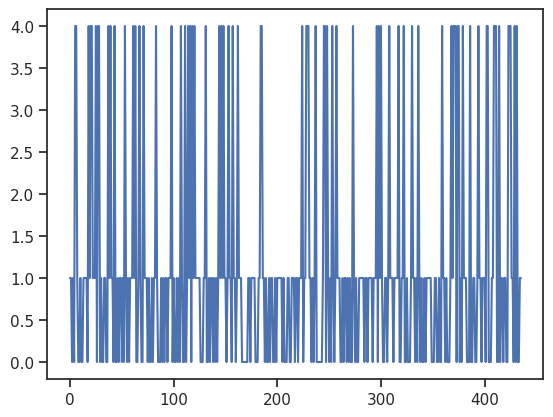

In [20]:
plt.plot(error)